# Exploratory Data Analysis (EDA) of the NOAA Severe Weather Data Inventory

In [175]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
import os, glob

In [79]:
# Commands to setup the notebook 
%load_ext autoreload
%autoreload 2

# Maximum number of lines to display
pd.options
pd.options.display.max_rows = 50

# Ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
# SOURCED FROM KAGGLE!!!
# Import each dataset seperately
folder_path = 'storm_data'

def load_files(folder_path, pattern):
    """
    Looks up all CSV files matching 'pattern' in the folder path,
    loads them into DataFrames, then concatenates them.
    """
    # Get the list of matching files using glob
    file_paths = glob.glob(f"{folder_path}/{pattern}")
    
    # Use tqdm to show progress while loading files
    dataframes = []
    for file_path in tqdm(file_paths, desc=f"Loading {pattern}"):
        df = pd.read_csv(file_path, low_memory=False)
        if not df.empty:
            dataframes.append(df)
    
    if dataframes:
        return pd.concat(dataframes).reset_index(drop=True)
    else:
        return pd.DataFrame()  # Return empty DataFrame if no files match


# Keep 3 separate DataFrames (exactly as shown):
df_fatalities = load_files(folder_path, "*fatalities*.csv")
df_locations  = load_files(folder_path, "*locations*.csv")
df_details    = load_files(folder_path, "*details*.csv")

 27%|██▋       | 55/203 [07:43<20:47,  8.43s/it]


In [81]:
# SOURCED FROM KAGGLE!!!
# Convert SOURCE to title case
df_details.SOURCE = df_details.SOURCE.str.title()

# List of acronyms that should be uppercase
ACRONYMS = ['Asos','Awos','Awss','Nws', 'C-Man','Raws','Shave','Snotel', 'Wlon']
for acronym in ACRONYMS:
    pattern = f'\\b{acronym}\\b'
    replacement = acronym.upper()
    df_details.SOURCE = df_details.SOURCE.str.replace(pattern, replacement, regex=True)

# One-off substitutions
source_substitutions = {
    'Arpt Equip(AWOS,ASOS)':'AWOS,ASOS,Mesonet,Etc',
    'Coastal Observing Station':'Coast Guard',
    'Cocorahs':'CoCoRaHS',
    'Coop Observer':'Cooperative Network Observer',
    'Coop Station':'Cooperative Network Observer',
    'Dept Of Highways':'Department Of Highways',
    'Fire Dept/Rescue Squad':'Fire Department/Rescue',
    'General Public':'Public',
    'Govt Official':'State Official',
    'Manual Input':'Unknown',
    'Meteorologist(Non NWS)' : 'Public',
    'NWS Employee(Off Duty)':'NWS Employee',
    'Npop':'Unknown',
    'Official NWS Obs.':'Official NWS Observations'
}

for original, replacement in source_substitutions.items():
    df_details.SOURCE = df_details.SOURCE.str.replace(original, replacement)

In [82]:
# SOURCED FROM KAGGLE!!!
event_substitution = {
    r'^HAIL.*' : 'Hail',
    r'^High Snow$' : 'Heavy Snow',
    r'^Hurricane$' : 'Hurricane (Typhoon)',
    r'^OTHER$' : 'Dust Devil',
    r'^THUNDERSTORM WIND.*' : 'Thunderstorm Wind',
    r'^TORNADO.*' : 'Tornado',
    r'^Volcanic Ashfall.*$' : 'Volcanic Ash'
    }
for original, replacement in event_substitution.items():
    df_details.EVENT_TYPE = df_details.EVENT_TYPE.str.replace( original, replacement, regex=True)

In [83]:
# SOURCED FROM KAGGLE!!!
timezone_substitutions = {
    "CDT" : "CST",
    "CSC" : "CST", # event was in Iowa
    'EDT' : 'EST',
    'GMT' : 'CST', # event was in Louisiana
    'GST' : 'ChST', # events were in Guam, which uses Chamorro Standard Time
    'MDT' : 'MST',
    'PDT' : 'PST',
    'SCT' : 'CST', # event was in Wisconsin
    }
unknown_timezones = {
    'HAWAII' : 'HST',
    'OKLAHOMA' : 'CST',
    'MASSACHUSETTS' : 'EST',
    'GEORGIA' : 'EST',
    'ILLINOIS' : 'CST'
    }

df_details.CZ_TIMEZONE = df_details.CZ_TIMEZONE.str.replace(r'-*\d*$','',regex=True).str.upper()

for original, replacement in timezone_substitutions.items():
    df_details.CZ_TIMEZONE = df_details.CZ_TIMEZONE.str.replace(original, replacement)
    
for index, row in df_details.query('CZ_TIMEZONE=="UNK"').iterrows():
    df_details.at[index, 'CZ_TIMEZONE'] = unknown_timezones.get(row.STATE, 'UNK')

In [84]:
# SOURCED FROM KAGGLE!!!
def create_datetime( df, prefix):
    df_components =  pd.to_datetime({
        'year' : df[ f"{prefix}YEARMONTH"] // 100,
        'month' : df[ f"{prefix}YEARMONTH"] % 100,
        'day' : df[ f"{prefix}DAY"],
        'hour' : df[ f"{prefix}TIME"]//100 ,
        'minute' : df[ f"{prefix}TIME"]%100,
        })
    return pd.to_datetime( df_components )

legacy = ['BEGIN_YEARMONTH', 'BEGIN_DAY', 'BEGIN_TIME', 'BEGIN_DATE_TIME']
legacy = legacy + ['END_YEARMONTH', 'END_DAY', 'END_TIME', 'END_DATE_TIME']
legacy = legacy + ['MONTH_NAME', 'YEAR']

df_details['BEGIN_DATETIME'] = create_datetime( df_details, 'BEGIN_')
df_details['END_DATETIME'] = create_datetime( df_details, 'END_')
df_details = df_details.drop(columns=legacy)

In [85]:
# SOURCED FROM KAGGLE!!!
def to_price( column ):
    price = column[ column.notnull()].astype('str').str.upper()
    
    valid_price = r'^[\d.]+[KMB]?$'
    price = price[ price.str.contains(valid_price, regex=True)]
    has_K = price.str.contains('K')
    has_M = price.str.contains('M')
    has_B = price.str.contains('B')
    price = price.str.replace(r'[KMB]','', regex=True).astype('float')
    
    scale = np.select([has_K, has_M, has_B], [1000, 1_000_000, 1_000_000_000], 1)
    return scale * price

df_details.DAMAGE_PROPERTY = to_price( df_details.DAMAGE_PROPERTY)
df_details.DAMAGE_CROPS = to_price( df_details.DAMAGE_CROPS)

In [86]:
# This fields have been converted to floats but should be integers
df_details.EPISODE_ID = df_details.EPISODE_ID.astype('Int64')
df_details.STATE_FIPS = df_details.STATE_FIPS.astype('Int64')

# Exploratory data analysis time!

In [87]:
# Keep only the first letter as a capital
df_details.columns   = df_details.columns.str.title()

In [ ]:
print(f"Number of samples in the Dataset: {df_details.shape[0]}")
print(f"Nusmber of columns in the Dataset: {df_details.shape[1]}")
display(df_details.head())

Number of samples in the Dataset: 1941100
Number of columns in the Dataset: 43


,Episode_Id,Event_Id,State,State_Fips,Event_Type,Cz_Type,Cz_Fips,Cz_Name,Wfo,Cz_Timezone,...,End_Location,Begin_Lat,Begin_Lon,End_Lat,End_Lon,Episode_Narrative,Event_Narrative,Data_Source,Begin_Datetime,End_Datetime
0,83473,503953,NEW HAMPSHIRE,33,Heavy Snow,Z,12,EASTERN HILLSBOROUGH,BOX,EST,...,NaN,NaN,NaN,NaN,NaN,Low pressure developing south of Long Island a...,Eight to twelve inches of snow fell across eas...,CSV,2014-02-18 10:00:00,2014-02-18 20:00:00
1,83491,504065,NEW HAMPSHIRE,33,Heavy Snow,Z,12,EASTERN HILLSBOROUGH,BOX,EST,...,NaN,NaN,NaN,NaN,NaN,Low pressure moving off the mid-Atlantic coast...,Six to twelve inches of snow fell across easte...,CSV,2014-02-05 03:00:00,2014-02-05 23:00:00
2,82185,494521,NEW HAMPSHIRE,33,Heavy Snow,Z,12,EASTERN HILLSBOROUGH,BOX,EST,...,NaN,NaN,NaN,NaN,NaN,Low pressure brought a brief period of heavy s...,Four to eight inches of snow fell across easte...,CSV,2014-01-18 10:00:00,2014-01-19 07:00:00
3,91728,549746,NEW HAMPSHIRE,33,Heavy Snow,Z,12,EASTERN HILLSBOROUGH,BOX,EST,...,NaN,NaN,NaN,NaN,NaN,A strong coastal storm moved up the east coast...,Six to eight inches of snow fell across easter...,CSV,2014-11-26 10:00:00,2014-11-27 10:00:00
4,83476,503982,NEW HAMPSHIRE,33,Heavy Snow,Z,12,EASTERN HILLSBOROUGH,BOX,EST,...,NaN,NaN,NaN,NaN,NaN,A significant winter storm brought six to twel...,Five to eight inches of snow fell across easte...,CSV,2014-02-13 06:30:00,2014-02-14 08:00:00


In [140]:
# Check for missing values
missing_values_per_col = df_details.isna().sum()
percentage_missing_total = missing_values_per_col .sum()/ (df_details.size) * 100
print(f"There are exactly: {percentage_missing_total}% missing values in the dataset.")

# Find the 3 columns with the most missing values
top_3_missing_columns = np.array(missing_values_per_col.sort_values(ascending=False).index[:3])
print(f"The 3 columns with the most missing values are: {top_3_missing_columns[0]}, {top_3_missing_columns[1]} and {top_3_missing_columns[2]}.")

num_rows = df_details.shape[0]
percentage_missing_top_3 = np.array(missing_values_per_col.sort_values(ascending=False).values[:3]) / num_rows
print(f"The percentage of missing values in the top 3 columns are: {percentage_missing_top_3[0]:.2%}, {percentage_missing_top_3[1]:.2%} and {percentage_missing_top_3[2]:.2%}.")

There are exactly: 37.5393848848591% missing values in the dataset.
The 3 columns with the most missing values are: Category, Tor_Other_Cz_State and Tor_Other_Cz_Fips.
The percentage of missing values in the top 3 columns are: 99.97%, 99.82% and 99.82%.


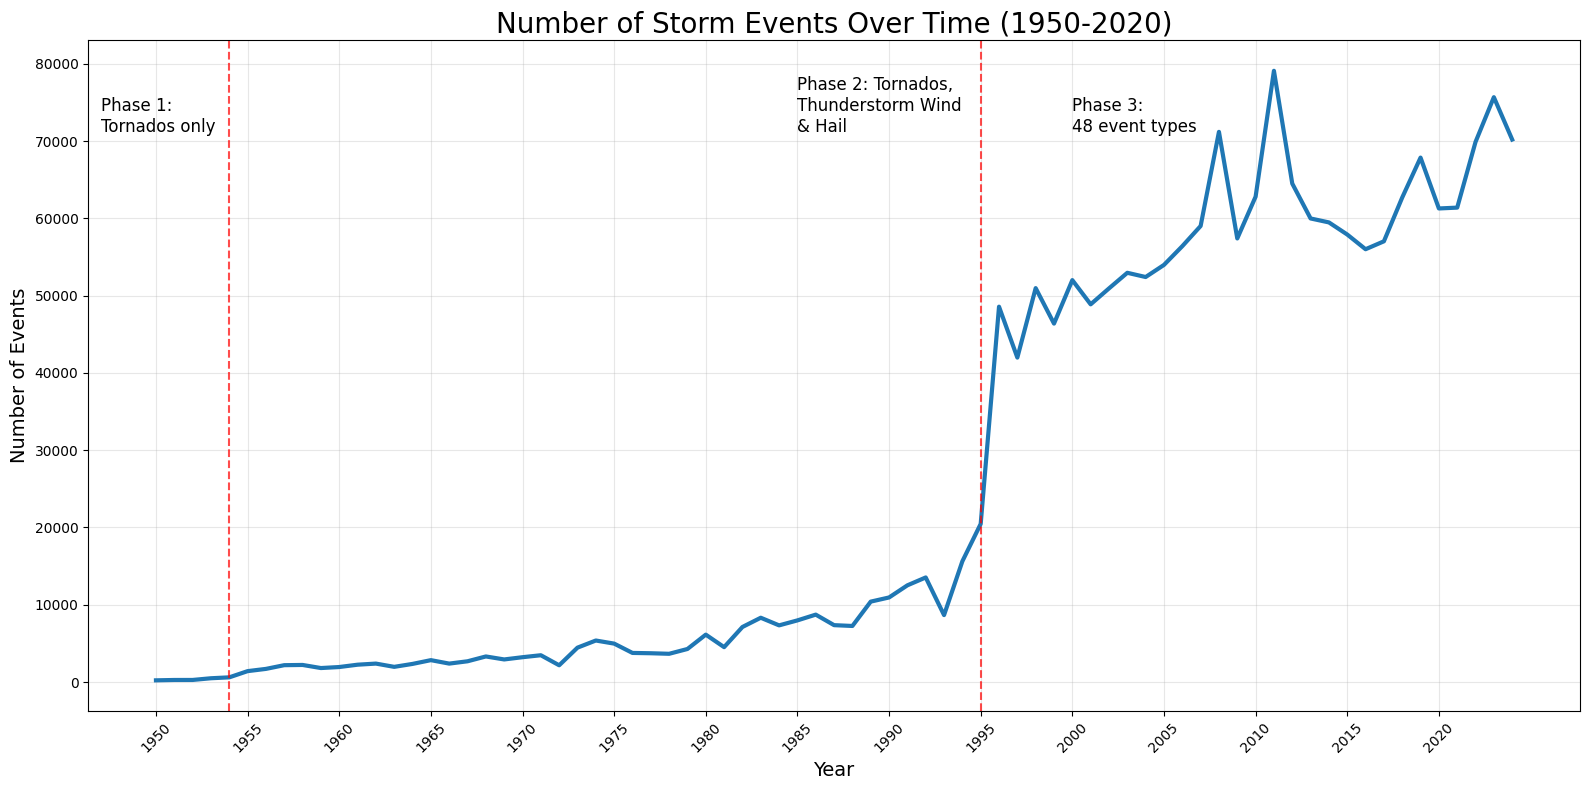

In [166]:
# Count events by year
events_by_year = df_details['Begin_Datetime'].dt.year.value_counts().sort_index()

# Create a line plot
plt.figure(figsize=(16, 8))
plt.plot(events_by_year.index, events_by_year.values, linewidth=3, color='#1f77b4')
plt.title('Number of Storm Events Over Time (1950-2020)', fontsize=20)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Events', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(range(min(events_by_year.index), max(events_by_year.index)+1, 5), rotation=45)
plt.tight_layout()

# Add annotations for key periods
plt.axvline(x=1954, color='red', linestyle='--', alpha=0.7)
plt.axvline(x=1995, color='red', linestyle='--', alpha=0.7)
plt.text(1947, events_by_year.max()*0.9, 'Phase 1: \nTornados only', fontsize=12)
plt.text(1985, events_by_year.max()*0.9, 'Phase 2: Tornados, \nThunderstorm Wind \n& Hail', fontsize=12)
plt.text(2000, events_by_year.max()*0.9, 'Phase 3: \n48 event types', fontsize=12)

plt.show()

In [161]:
df_details['Begin_Datetime'].dt.year.value_counts().sort_index()

Begin_Datetime
1950      223
1951      269
1952      272
1953      492
1954      609
        ...  
2020    61279
2021    61389
2022    69886
2023    75677
2024    70196
Name: count, Length: 75, dtype: int64

In [199]:
state_counts = df_details['State'].value_counts()
state_counts = pd.DataFrame({'State': state_counts.index, 'Event_Count': state_counts.values})

In [200]:
# Create a mapping dictionary from uppercase state names to 2-letter codes
state_name_to_code = {
    'ALABAMA': 'AL', 'ALASKA': 'AK', 'ARIZONA': 'AZ', 'ARKANSAS': 'AR', 'CALIFORNIA': 'CA',
    'COLORADO': 'CO', 'CONNECTICUT': 'CT', 'DELAWARE': 'DE', 'FLORIDA': 'FL', 'GEORGIA': 'GA',
    'HAWAII': 'HI', 'IDAHO': 'ID', 'ILLINOIS': 'IL', 'INDIANA': 'IN', 'IOWA': 'IA',
    'KANSAS': 'KS', 'KENTUCKY': 'KY', 'LOUISIANA': 'LA', 'MAINE': 'ME', 'MARYLAND': 'MD',
    'MASSACHUSETTS': 'MA', 'MICHIGAN': 'MI', 'MINNESOTA': 'MN', 'MISSISSIPPI': 'MS', 'MISSOURI': 'MO',
    'MONTANA': 'MT', 'NEBRASKA': 'NE', 'NEVADA': 'NV', 'NEW HAMPSHIRE': 'NH', 'NEW JERSEY': 'NJ',
    'NEW MEXICO': 'NM', 'NEW YORK': 'NY', 'NORTH CAROLINA': 'NC', 'NORTH DAKOTA': 'ND', 'OHIO': 'OH',
    'OKLAHOMA': 'OK', 'OREGON': 'OR', 'PENNSYLVANIA': 'PA', 'RHODE ISLAND': 'RI', 'SOUTH CAROLINA': 'SC',
    'SOUTH DAKOTA': 'SD', 'TENNESSEE': 'TN', 'TEXAS': 'TX', 'UTAH': 'UT', 'VERMONT': 'VT',
    'VIRGINIA': 'VA', 'WASHINGTON': 'WA', 'WEST VIRGINIA': 'WV', 'WISCONSIN': 'WI', 'WYOMING': 'WY',
    'DISTRICT OF COLUMBIA': 'DC', 'AMERICAN SAMOA': 'AS', 'GUAM': 'GU', 'NORTHERN MARIANA ISLANDS': 'MP',
    'PUERTO RICO': 'PR', 'UNITED STATES VIRGIN ISLANDS': 'VI', 'U.S. VIRGIN ISLANDS': 'VI'
}

# Map the state names to codes
state_counts['State_Code'] = state_counts['State'].map(state_name_to_code)

# Create a choropleth map using the state codes
fig = px.choropleth(state_counts, 
                    locations='State_Code',  # Use the new column with state codes
                    locationmode='USA-states',
                    color='Event_Count',
                    scope='usa',
                    color_continuous_scale='Viridis',
                    title='Storm Events by State (1950-2020)')

fig.update_layout(
    title_font_size=20,
    coloraxis_colorbar=dict(
        title=dict(
            text='Number of Events',
            font=dict(size=14)
        )
    ),
    geo=dict(
        lakecolor='rgb(255, 255, 255)',
        showlakes=True
    ),
    height=600
)

fig.show()

In [196]:
state_counts.head()

,State,Event_Count
0,TEXAS,156860
1,KANSAS,90396
2,OKLAHOMA,78486
3,MISSOURI,69323
4,IOWA,67200


In [69]:
folder_path = 'storm_data'

# Load the data
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

# Read all the dfs into a list
dfs = [df for df in (pd.read_csv(os.path.join(folder_path, file), low_memory=False) for file in tqdm(csv_files)) if not df.empty]
print(f"There are {len(dfs)} non-empty dataframes in the list")

100%|██████████| 203/203 [00:08<00:00, 23.29it/s]


There are 180 non-empty dataframes in the list


In [5]:
columns_list = {tuple(df.columns) for df in dfs}
print(f"As expected there are {len(columns_list)} sets of columns since there are the following different dataset types; details, locations and fatalities")

As expected there are 3 sets of columns since there are the following different dataset types; details, locations and fatalities


In [35]:
columns_lista

{('BEGIN_YEARMONTH',
  'BEGIN_DAY',
  'BEGIN_TIME',
  'END_YEARMONTH',
  'END_DAY',
  'END_TIME',
  'EPISODE_ID',
  'EVENT_ID',
  'STATE',
  'STATE_FIPS',
  'YEAR',
  'MONTH_NAME',
  'EVENT_TYPE',
  'CZ_TYPE',
  'CZ_FIPS',
  'CZ_NAME',
  'WFO',
  'BEGIN_DATE_TIME',
  'CZ_TIMEZONE',
  'END_DATE_TIME',
  'INJURIES_DIRECT',
  'INJURIES_INDIRECT',
  'DEATHS_DIRECT',
  'DEATHS_INDIRECT',
  'DAMAGE_PROPERTY',
  'DAMAGE_CROPS',
  'SOURCE',
  'MAGNITUDE',
  'MAGNITUDE_TYPE',
  'FLOOD_CAUSE',
  'CATEGORY',
  'TOR_F_SCALE',
  'TOR_LENGTH',
  'TOR_WIDTH',
  'TOR_OTHER_WFO',
  'TOR_OTHER_CZ_STATE',
  'TOR_OTHER_CZ_FIPS',
  'TOR_OTHER_CZ_NAME',
  'BEGIN_RANGE',
  'BEGIN_AZIMUTH',
  'BEGIN_LOCATION',
  'END_RANGE',
  'END_AZIMUTH',
  'END_LOCATION',
  'BEGIN_LAT',
  'BEGIN_LON',
  'END_LAT',
  'END_LON',
  'EPISODE_NARRATIVE',
  'EVENT_NARRATIVE',
  'DATA_SOURCE'),
 ('FAT_YEARMONTH',
  'FAT_DAY',
  'FAT_TIME',
  'FATALITY_ID',
  'EVENT_ID',
  'FATALITY_TYPE',
  'FATALITY_DATE',
  'FATALITY_AGE',
  '

In [ ]:
# Combine the dfs together by using 'episode_id' and 'event_id' as the key (as described in the pdf)
combined_df = dfs[0]

# Loop through the rest of the dfs and merge them with the combined_df, Event fatalities doesn't have episode_id
for df in dfs[1:]:
    if 'episode_id' in df.columns and 'episode_id' in combined_df.columns:
        join_cols = ['episode_id', 'event_id']
    elif 'event_id' in df.columns and 'event_id' in combined_df.columns:
        join_cols = ['event_id']
    else:
        # No matching keys, skip
        continue
    combined_df = pd.merge(combined_df, df, on=join_cols, how='outer')

print("Final shape:", combined_df.shape)

Final shape: (22, 11)


In [10]:
# Concatenate the dfs together
concat_df = pd.concat(dfs, axis=0)
print("Final shape:", concat_df.shape)

Final shape: (3690781, 70)


In [27]:
concat_df.head()

,FAT_YEARMONTH,FAT_DAY,FAT_TIME,FATALITY_ID,EVENT_ID,FATALITY_TYPE,FATALITY_DATE,FATALITY_AGE,FATALITY_SEX,FATALITY_LOCATION,...,DATA_SOURCE,YEARMONTH,LOCATION_INDEX,RANGE,AZIMUTH,LOCATION,LATITUDE,LONGITUDE,LAT2,LON2
0,195503.0,16.0,1430.0,1005348.0,10075750,D,03/16/1955 14:30:00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,195503.0,1.0,152.0,1005349.0,10083328,D,03/01/1955 01:52:00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,195503.0,13.0,2100.0,1005350.0,10117464,D,03/13/1955 21:00:00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,195503.0,22.0,1430.0,1005351.0,10117756,D,03/22/1955 14:30:00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,195504.0,21.0,141.0,1005352.0,9984179,D,04/21/1955 01:41:00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
concat_df.columns

Index(['FAT_YEARMONTH', 'FAT_DAY', 'FAT_TIME', 'FATALITY_ID', 'EVENT_ID',
       'FATALITY_TYPE', 'FATALITY_DATE', 'FATALITY_AGE', 'FATALITY_SEX',
       'FATALITY_LOCATION', 'EVENT_YEARMONTH', 'BEGIN_YEARMONTH', 'BEGIN_DAY',
       'BEGIN_TIME', 'END_YEARMONTH', 'END_DAY', 'END_TIME', 'EPISODE_ID',
       'STATE', 'STATE_FIPS', 'YEAR', 'MONTH_NAME', 'EVENT_TYPE', 'CZ_TYPE',
       'CZ_FIPS', 'CZ_NAME', 'WFO', 'BEGIN_DATE_TIME', 'CZ_TIMEZONE',
       'END_DATE_TIME', 'INJURIES_DIRECT', 'INJURIES_INDIRECT',
       'DEATHS_DIRECT', 'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS',
       'SOURCE', 'MAGNITUDE', 'MAGNITUDE_TYPE', 'FLOOD_CAUSE', 'CATEGORY',
       'TOR_F_SCALE', 'TOR_LENGTH', 'TOR_WIDTH', 'TOR_OTHER_WFO',
       'TOR_OTHER_CZ_STATE', 'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME',
       'BEGIN_RANGE', 'BEGIN_AZIMUTH', 'BEGIN_LOCATION', 'END_RANGE',
       'END_AZIMUTH', 'END_LOCATION', 'BEGIN_LAT', 'BEGIN_LON', 'END_LAT',
       'END_LON', 'EPISODE_NARRATIVE', 'EVENT_NARRATI

In [33]:
assert 'EVENT_ID' in concat_df.columns and 'EPISODE_ID' in concat_df.columns, "The columns 'EVENT_ID' and 'EPISODE_ID' are not in the dataframe"

In [23]:
# check out a random dataframe
dfs[50].head(5)

,FAT_YEARMONTH,FAT_DAY,FAT_TIME,FATALITY_ID,EVENT_ID,FATALITY_TYPE,FATALITY_DATE,FATALITY_AGE,FATALITY_SEX,FATALITY_LOCATION,EVENT_YEARMONTH
0,195807,1,1510,1005456,10055208,D,07/01/1958 15:10:00,NaN,NaN,NaN,195807
1,195808,4,1930,1005457,10055429,D,08/04/1958 19:30:00,NaN,NaN,NaN,195808
2,195809,7,1600,1005458,10040343,D,09/07/1958 16:00:00,NaN,NaN,NaN,195809
3,195810,19,735,1005459,9984944,D,10/19/1958 07:35:00,NaN,NaN,NaN,195810
4,195810,10,1905,1005460,10048193,D,10/10/1958 19:05:00,NaN,NaN,NaN,195810
